In [22]:
using Pkg
Pkg.activate("..") ## because we have environment files in the parent directory
Pkg.instantiate() ## to download all missing packages

  Activating project at `c:\Users\piotr\Dropbox\WNE\QuantEcon_all\QEcon2023\Code`

In [23]:
# load some packages we will need today
using Distributions, QuantEcon, IterTools, Plots, Optim, Interpolations, LinearAlgebra, Inequality, Statistics, ColorSchemes,PrettyTables, Roots

In [24]:
function create_grid(ha_block;N_a=70,a_max=40);
    a_min = -ha_block.ϕ

    a_vec= collect(range(a_min, a_max, length=N_a))
    return (; a_vec, N_a, a_min, a_max)
end


function create_ha_block(; 
    ρ_z=0.96, # log of productivity persistence
    ν_z=sqrt(0.025), # log of productivity volatility
    γ = 2, # curvature parameter of utility function
    u = γ == 1 ? x -> log(x) : x -> (x^(1 - γ) - 1) / (1 - γ), # utility function
    ϕ = 0.0, # borrowing constraint
    β= 0.98, # discount factor
    N_z= 9, # grid size for Tauchen
    mc_z = tauchen(N_z, ρ_z, ν_z, 0),
    λ_z = stationary_distributions(mc_z)[1],
    P_z = mc_z.p, # transition matrix
    z_vec = exp.(mc_z.state_values) / sum(exp.(mc_z.state_values) .* λ_z)) # normalize so that mean is 1
    return (; ρ_z, ν_z, γ,  u, ϕ, β, N_z, mc_z, z_vec, P_z , λ_z)
end

function getW!(W,V,a_vec,z_vec,P)
    for (i, a′) in enumerate(a_vec)
        for (j, z) in enumerate(z_vec)
            W[i,j] = sum(P[j,j′] .* V[i,j′] for j′ in eachindex(z_vec))
        end
    end
return W
end

function vfi(model,prices,grid;tol = 1e-6, maxiter = 2000)
    (; ρ_z, ν_z, γ,  u, ϕ, β, N_z, mc_z, z_vec, P_z , λ_z) = model
    (; a_vec, N_a, a_min, a_max) = grid
    (; r, w) = prices
    
    V = zeros(N_a,N_z) # initialize value function
    W = similar(V) # initialize W
    σ_a′ = similar(V) # initialize policy function
    σ_c = similar(V) # initialize policy function
    
    # get W
    getW!(W,V,a_vec,z_vec,P_z)
    error = 1 + tol
    iter = 1;
    while error > tol && iter < maxiter
        V_new, (σ_a′,σ_c) = T_operator(W, model,prices, grid)
        error = maximum(abs.(V_new .- V))
        getW!(W,V_new,a_vec,z_vec,P_z)
        V = V_new
        
        iter += 1
    end
    policies = (a′ = σ_a′, c= σ_c)

    return V, policies, error, iter
end


function T_operator(W, model, prices, grid; tol = 1e-10)
    
    (; ρ_z, ν_z, γ,  u, ϕ, β, N_z, mc_z, z_vec, P_z , λ_z) = model
    (; a_vec, N_a, a_min, a_max) = grid
    (; r, w) = prices
    W_hat = linear_interpolation((a_vec,z_vec),W,extrapolation_bc=Linear()) # linear interpolation of W

    TW = similar(W)
    σ_a′ = similar(W)
    σ_c = similar(W)
    for (i, a) in enumerate(a_vec)
        for (j, z) in enumerate(z_vec)
            # solve maximization for each point in (a,z), using a itself as initial condition.

            results = optimize(a′ -> -u( (1+r)*a-a′+w*z) -
                                    β * W_hat(a′,z), a_min, (1+r)*a+w*z,GoldenSection(),g_tol=1e-8)
            TW[i,j] = -Optim.minimum(results)
            σ_a′[i,j] = Optim.minimizer(results)
            σ_c[i,j] = (1+r)*a + w*z - σ_a′[i,j]
        end
    end
    policies = (a′ = σ_a′, c= σ_c)
    return TW, policies 
end

# function from https://discourse.julialang.org/t/findnearest-function/4143/4
function closest_index(a::Vector,x::Real)

    if isempty(a) == true
      error("xGrid is empty in function closest_index.")
    end

    if isnan(x) == true
      error("val is NaN in function closest_index.")
    end

   idx = searchsortedfirst(a,x)
   if (idx==1); return idx; end
   if (idx>length(a)); return length(a); end
   if (a[idx]==x); return idx; end
   if (abs(a[idx]-x) < abs(a[idx-1]-x))
      return idx
   else
      return idx-1
   end
end

function closest_value_and_index(xGrid::Vector, val::Real)

   # get index
   ibest = closest_index(xGrid, val)

   # Return best value on grid, and the corresponding index
   return xGrid[ibest], ibest

end

function get_q(w_grid,w) # code from https://julienpascal.github.io/post/young_2010/


    w_min = minimum(w_grid)
    w_max = maximum(w_grid)
    nW = length(w_grid)
    
    q = zeros(length(w_grid),length(w_grid))
    
    
        for (wIndexTrue, w_temp) in enumerate(w_grid)
    
    
            # Project true value on the grid:
            (wValue_proj, wIndex_proj) = closest_value_and_index(w_grid, w[wIndexTrue])
    
            # To store the location of the value below and above the true value:
            wIndex_below = 0
            wIndex_above = 0
    
            # If the true value is above the projection
            if w[wIndexTrue] >= wValue_proj
                wIndex_below = wIndex_proj
                wIndex_above = wIndex_proj + 1
            # If the true value is below the projection
            elseif w[wIndexTrue] < wValue_proj
                wIndex_below = wIndex_proj -1
                wIndex_above = wIndex_proj
            end
    
            # Boundary cases
            if wIndex_proj == 1
                wIndex_below = 1
                wIndex_above = 2
            elseif wIndex_proj == nW
                wIndex_below = nW - 1
                wIndex_above = nW
            end
    
            # Special case 1: w < w_min
            if w[wIndexTrue] <= w_min
                p = 1
            elseif w[wIndexTrue] >= w_max
            # Special case 2: w > w_max
                p = 0
            else
                p = 1.0 - ((w[wIndexTrue] - w_grid[wIndex_below])/(w_grid[wIndex_above] - w_grid[wIndex_below]))
                p = min(1.0, max(0.0, p))
            end
    
        
    
        q[wIndexTrue, wIndex_below] = p
        q[wIndexTrue, wIndex_above] = 1.0 - p
    end
    
        return q
    end

function get_transition(model, policies, grid)

    (; ρ_z, ν_z, γ,  u, ϕ, β, N_z, mc_z, z_vec, P_z , λ_z) = model
    (; a_vec, N_a, a_min, a_max) = grid
    
    Q = zeros(N_a * N_z,N_a * N_z)
    
    
    for (j, z) in enumerate(z_vec)
            for (j′, z′) in enumerate(z_vec)
                    Q[(j-1)*N_a+1:j*N_a,(j′-1)*N_a+1:j′*N_a] = get_q(a_vec,policies.a′[:,j]) .* P_z[j,j′]
            end
    end
    
    
    return Q
    end

function stationary_distribution_hh(model, policies, grid)

    Q = get_transition(model, policies, grid)

    N_a = grid.N_a
    N_z = model.N_z    
    z_vec = model.z_vec

    λ_vector = (Q^10000)[1,:]
    λ = zeros(N_a, N_z)

    for (j, z) in enumerate(z_vec)
        for (j, z′) in enumerate(z_vec)
            λ[:,j] = λ_vector[(j-1)*N_a+1:j*N_a]
        end
    end

    λ_a = sum(λ,dims=2)
    λ_z = sum(λ,dims=1)'
    return λ, λ_vector, λ_a, λ_z
end 

function show_statistics_hugget(ha_block,grid,λ_a,λ_z)
# warning - this can be misleading if we allow for negative values!
lorenz_a_pop,lorenz_a_share=lorenz_curve(grid.a_vec,vec(λ_a))
lorenz_z_pop,lorenz_z_share=lorenz_curve(ha_block.z_vec,vec(λ_z))



lorenz_a = LinearInterpolation(lorenz_a_pop, lorenz_a_share);
lorenz_z = LinearInterpolation(lorenz_z_pop, lorenz_z_share);


header = (["", "Assets", "Income"])

data = [           
                     "Bottom 50% share"         lorenz_a(0.5)        lorenz_z(0.5)    ;
                     "Top 10% share"            1-lorenz_a(0.9)         1-lorenz_z(0.9)     ;
                     "Top 1% share"             1-lorenz_a(0.99)        1-lorenz_z(0.99)    ;  
                     "Gini Coefficient"      wgini(grid.a_vec,vec(max.(0,λ_a)))      wgini(ha_block.z_vec,vec(max.(0.0,λ_z)))    ;]

return pretty_table(data;header=header,formatters=ft_printf("%5.3f",2:3))
end

function solve_hh_block(grid,model,prices)
    V, policies, error, iter = vfi(model,prices,grid)
    λ, λ_vector, λ_a, λ_z = stationary_distribution_hh(model, policies, grid)
    A′ = sum(λ .* policies.a′)
    C  = sum(λ .* policies.c)


    return V, policies, error, iter, λ, λ_vector, λ_a, λ_z, A′, C
end
    

solve_hh_block (generic function with 1 method)

In [25]:
ha_block = create_ha_block(;ϕ=2,N_z = 7)
grid_a = create_grid(ha_block,a_max=100,N_a = 100)

(a_vec = [-2.0, -0.9696969696969697, 0.06060606060606061, 1.0909090909090908, 2.121212121212121, 3.1515151515151514, 4.181818181818182, 5.212121212121212, 6.242424242424242, 7.2727272727272725  …  90.72727272727273, 91.75757575757575, 92.78787878787878, 93.81818181818181, 94.84848484848484, 95.87878787878788, 96.9090909090909, 97.93939393939394, 98.96969696969697, 100.0], N_a = 100, a_min = -2, a_max = 100)

In [26]:
function asset_demand_hugget(r)
    w = 1
    prices = (r = r,w = w)
    V, policies, error, iter, λ, λ_vector, λ_a, λ_z, A′, C = solve_hh_block(grid_a,ha_block,prices)
    
    display("value function iteration error = $error")

    return A′
end


asset_demand_hugget (generic function with 1 method)

In [27]:
asset_demand_hugget(-0.0)

"value function iteration error = 9.95931600300537e-7"

6.304634570934758

"value function iteration error = 9.807596015320996e-7"

"value function iteration error = 9.945241750131117e-7"

"value function iteration error = 9.855772020728182e-7"

"value function iteration error = 9.800200331255837e-7"

"value function iteration error = 9.818147859164128e-7"

"value function iteration error = 9.938698326550366e-7"

"value function iteration error = 9.982078026382624e-7"

"value function iteration error = 9.959579969631704e-7"

"value function iteration error = 9.879039168936288e-7"

"value function iteration error = 9.935102127656137e-7"

"value function iteration error = 9.879867448603363e-7"

"value function iteration error = 9.809749599298812e-7"

"value function iteration error = 9.970469960762784e-7"

"value function iteration error = 9.813182941798004e-7"

"value function iteration error = 9.9432585187742e-7"

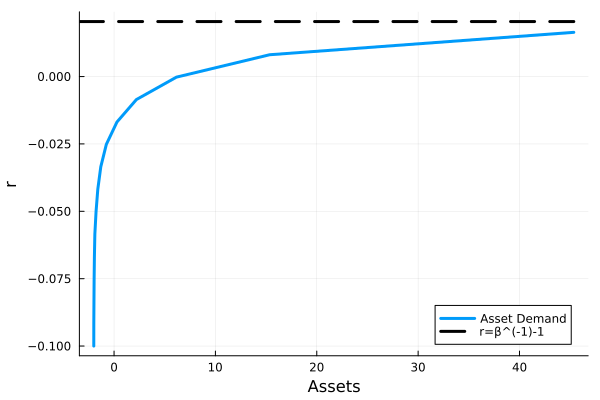

In [28]:
grid_r = LinRange(-0.1,ha_block.β^(-1)-1-0.004,15)
plot(asset_demand_hugget.(grid_r),grid_r,label="Asset Demand",ylabel="r",xlabel="Assets",legend=:bottomright,linewidth=3)
hline!([ha_block.β^(-1)-1],label="r=β^(-1)-1",linewidth=3,linestyle=:dash,color=:black)

In [29]:
function asset_residual_hugget(r)
   return asset_demand_hugget(r)
end

asset_residual_hugget (generic function with 1 method)

In [30]:
r_eqm = find_zero(asset_residual_hugget, (-0.025, ha_block.β^(-1)-1-0.01 ))
display("Equilibrium interest rate is $r_eqm")
display("Aggregate excess asset demand $(asset_demand_hugget(r_eqm))") 


"value function iteration error = 9.955337532119302e-7"

"value function iteration error = 9.835752337039594e-7"

"value function iteration error = 9.95931600300537e-7"

"value function iteration error = 9.95931600300537e-7"

"value function iteration error = 9.95931600300537e-7"

"value function iteration error = 9.95931600300537e-7"

"value function iteration error = 9.95931600300537e-7"

"value function iteration error = 9.95931600300537e-7"

"value function iteration error = 9.95933735481458e-7"

"value function iteration error = 9.964523997041397e-7"

"value function iteration error = 9.815869859153281e-7"

"value function iteration error = 9.935633720203896e-7"

"value function iteration error = 9.89690306596458e-7"

"value function iteration error = 9.839778130071863e-7"

"value function iteration error = 9.812220795879512e-7"

"value function iteration error = 9.830802980559383e-7"

"value function iteration error = 9.936516249808847e-7"

"value function iteration error = 9.88390091549718e-7"

"value function iteration error = 9.91026645635884e-7"

"value function iteration error = 9.89709818099982e-7"

"value function iteration error = 9.890503349652136e-7"

"value function iteration error = 9.88720309180735e-7"

"value function iteration error = 9.8888534694197e-7"

"value function iteration error = 9.888028387194936e-7"

"value function iteration error = 9.888440857253045e-7"

"value function iteration error = 9.888234586696854e-7"

"value function iteration error = 9.888131415891621e-7"

"value function iteration error = 9.888183143402784e-7"

"value function iteration error = 9.888208793995545e-7"

"value function iteration error = 9.888195933172028e-7"

"value function iteration error = 9.888202399110924e-7"

"value function iteration error = 9.888199201668613e-7"

"value function iteration error = 9.88819756742032e-7"

"value function iteration error = 9.888198277963056e-7"

"value function iteration error = 9.888198704288698e-7"

"value function iteration error = 9.88819856218015e-7"

"value function iteration error = 9.888198384544467e-7"

"value function iteration error = 9.88819834901733e-7"

"value function iteration error = 9.88819834901733e-7"

"value function iteration error = 9.88819834901733e-7"

"value function iteration error = 9.88819834901733e-7"

"value function iteration error = 9.888198420071603e-7"

"value function iteration error = 9.888198420071603e-7"

"value function iteration error = 9.88819834901733e-7"

"value function iteration error = 9.88819834901733e-7"

"value function iteration error = 9.888198420071603e-7"

"value function iteration error = 9.88819834901733e-7"

"value function iteration error = 9.88819834901733e-7"

"value function iteration error = 9.88819834901733e-7"

"value function iteration error = 9.888198420071603e-7"

"value function iteration error = 9.88819834901733e-7"

"value function iteration error = 9.888198491125877e-7"

"value function iteration error = 9.88819834901733e-7"

"value function iteration error = 9.888198420071603e-7"

"value function iteration error = 9.888198420071603e-7"

"value function iteration error = 9.88819834901733e-7"

"value function iteration error = 9.888198420071603e-7"

"value function iteration error = 9.88819834901733e-7"

"value function iteration error = 9.88819834901733e-7"

"value function iteration error = 9.88819834901733e-7"

"value function iteration error = 9.88819834901733e-7"

"value function iteration error = 9.88819834901733e-7"

"value function iteration error = 9.88819834901733e-7"

"value function iteration error = 9.88819834901733e-7"

"value function iteration error = 9.88819834901733e-7"

"Equilibrium interest rate is -0.01865254541900979"

"value function iteration error = 9.88819834901733e-7"

"Aggregate excess asset demand -5.765305444160873e-8"

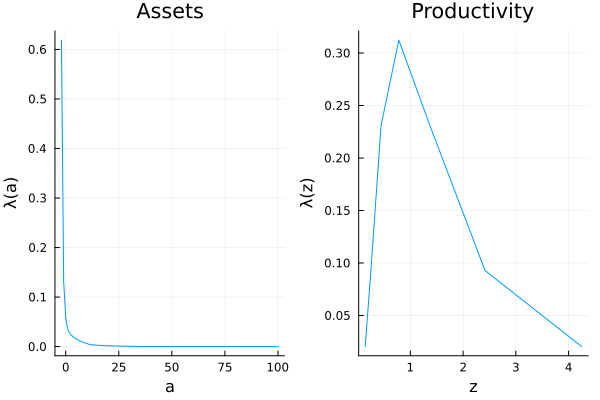

In [31]:
w = 1
prices_eqm = (r = r_eqm,w = w)
V, policies, error_vfi, iter, λ, λ_vector, λ_a, λ_z, A′, C = solve_hh_block(grid_a,ha_block,prices_eqm)

p_asset = plot(grid_a.a_vec, λ_a, xlabel = "a", ylabel = "λ(a)",title = "Assets", legend = false)
p_income = plot(ha_block.z_vec, λ_z, xlabel = "z", ylabel = "λ(z)", title = "Productivity",  legend = false)
plot(p_asset,p_income)